# Comparison of NN classifiers with alternative representations

In this project, we will perform Knn classifiers prediction for 5 different datasets which is provided by http://www.timeseriesclassification.com . All the datasets can be found at this website. We will perform Knn classifiers on raw dataset and 2  different presentation with 3 different presentation parameters and after this we will use 4 different distance parameter for each presentation. Finally best parameter combination will be choosen by comparing the cross validation accuracy measures. With the best parameters, predictions will be done.
    
                                                                                    Alperen Köksal

matrices[[1]] = train_raw

matrices[[2]] = tree piecewise representation with maxdepth = 2

matrices[[3]] = tree piecewise representation with maxdepth = 3

matrices[[4]] = tree piecewise representation with maxdepth = 4

matrices[[5]] = Piecewise Aggregate Approximation representation with segmenth length = 5

matrices[[6]] = Piecewise Aggregate Approximation representation with segmenth length = 10

matrices[[7]] = Piecewise Aggregate Approximation representation with segmenth length = 20

distances[[1,5,9,13,17,21,25] = Euclidean distance of matrices[[1,2,3,4,5,6,7]]
    
distances[[2,6,10,14,18,22,26]] = Dynamic time warping distance of matrices[[1,2,3,4,5,6,7]]
    
distances[[3,7,11,15,19,23,27]] = Longest common subsequence distances of matrices[[1,2,3,4,5,6,7]]
    
distances[[4,8,12,16,20,24,28]] = Manhattan distances of matrices[[1,2,3,4,5,6,7]]

In [126]:
library(data.table,quietly = TRUE,warn.conflicts = FALSE)
library(ggplot2,quietly = TRUE,warn.conflicts = FALSE)
library(lubridate,quietly = TRUE,warn.conflicts = FALSE)
library(forecast,quietly = TRUE,warn.conflicts = FALSE)
library(urca,quietly = TRUE,warn.conflicts = FALSE)
library(plotly,quietly = TRUE,warn.conflicts = FALSE)
library(scatterplot3d,quietly = TRUE,warn.conflicts = FALSE)
library(rpart,quietly = TRUE,warn.conflicts = FALSE)
library(rattle,quietly = TRUE,warn.conflicts = FALSE)
library(modelr)
library(resamplr)
library(caret)
library(TSrepr)
library(repr)
library(zoo)
library(Rfast)
library(TSdist)
library(dtw)
library(TunePareto)
library(FastKNN)
library(readr)

Required cross validation knn classify function which is provided our teacher. It basicly takes 4 inputs: distance matrix, class of train set instances, indices that we will do test on, and k value.

In [3]:
nn_classify_cv=function(dist_matrix,train_class,test_indices,k=1){
    
    test_distances_to_train=dist_matrix[test_indices,]
    test_distances_to_train=test_distances_to_train[,-test_indices]
    train_class=train_class[-test_indices]
    #print(str(test_distances_to_train))
    ordered_indices=apply(test_distances_to_train,1,order)
    if(k==1){
        nearest_class=as.numeric(trainclass[as.numeric(ordered_indices[1,])])
        nearest_class=data.table(id=test_indices,nearest_class)
    } else {
        nearest_class=apply(ordered_indices[1:k,],2,function(x) {trainclass[x]})
        nearest_class=data.table(id=test_indices,t(nearest_class))
    }
    
    long_nn_class=melt(nearest_class,'id')

    class_counts=long_nn_class[,.N,list(id,value)]
    class_counts[,predicted_prob:=N/k]
    wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
    wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
    class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]
    
    
    return(list(prediction=class_predictions,prob_estimates=wide_class_prob_predictions))
}

# 1) GunPoint dataset

This dataset is a remake of the famous GunPoint dataset released in 2003. We strive to mimic in every aspect the recording of the original GunPoint. The actors include one male and one female. They are the same actors who created the original GunPoint.

We record two scenarios, Gun and Point (also known as Gun and NoGun). In each scenario, the actors aim at a eye-level target. The difference between Gun and Point is that for the Gun scenario, the actors hold a gun, and in the Point scenario, the actors point with just their fingers. A complete Gun action involves the actor moves hand from an initial rest position, points the gun at target, puts gun back to waist holster and then brings free hand to the initial rest position. Each complete action conforms to a five-second cycle. With 30fps, this translates into 150 frames per action. We extract the centroid of the hand from each frame and use its x-axis coordinate to form a time series.

We refer to the old GunPoint as GunPoint 2003 and the new GunPoint as Gunpoint 2018. We merged GunPoint 2003 and GunPoint 2018 to make three datasets.

Let us denote:
- G: Gun
- P: Point
- M: Male
- F: Female
- 03: The year 2003
- 18: The year 2018

## GunPointAgeSpan 

The task is to classify Gun and Point. There are 4 flavors of each class.
- Class 1: Gun (FG03, MG03, FG18, MG18)
- Class 2: Point (FP03, MP03, FP18, MP18)

Train size: 135

Test size: 316

Number of classes: 2

Missing value: No

Time series length: 150

## GunPointMaleVersusFemale

The task is to classify Male and Female. There are 4 flavors of each class.
- Class 1: Female (FG03, FP03, FG18, FP18)
- Class 2: Male (MG03, MP03, MG18, MP18)

Train size: 135

Test size: 316

Number of classes: 2

Missing value: No

Time series length: 150

## GunPointOldVersusYoung

The task is to classify the older and younger version of the actors. There are 4 flavors of each class.
- Class 1: Young (FG03, MG03, FP03, MP03)
- Class 2: Old (FG18, MG18, FP18, MP18)

Train size: 135

Test size: 316

Number of classes: 2

Missing value: No

Time series length: 150

There is nothing to infer from the order of examples in the train and test set.

Data created by Ann Ratanamahatana and Eamonn Keogh. Data edited by Hoang Anh Dau.



In [4]:
setwd("C:/Users/a_kok/Desktop/Dersler/IE 48B/HW3")
gunpoint_train <- fread("GunPointOldVersusYoung_TRAIN.txt")
gunpoint_test <- fread("GunPointOldVersusYoung_TEST.txt")

In [5]:
setnames(gunpoint_train,"V1","class")
gunpoint_train=gunpoint_train[order(class)]
gunpoint_train[,class:=as.character(class)]
gunpoint_train[,id:=1:.N]
long_gunpoint_train=melt(gunpoint_train,id.vars=c('id','class'))
long_gunpoint_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_gunpoint_train=long_gunpoint_train[,list(id,class,time,value)]
long_gunpoint_train=long_gunpoint_train[order(id,time)]

Representations of three instances from both classes.

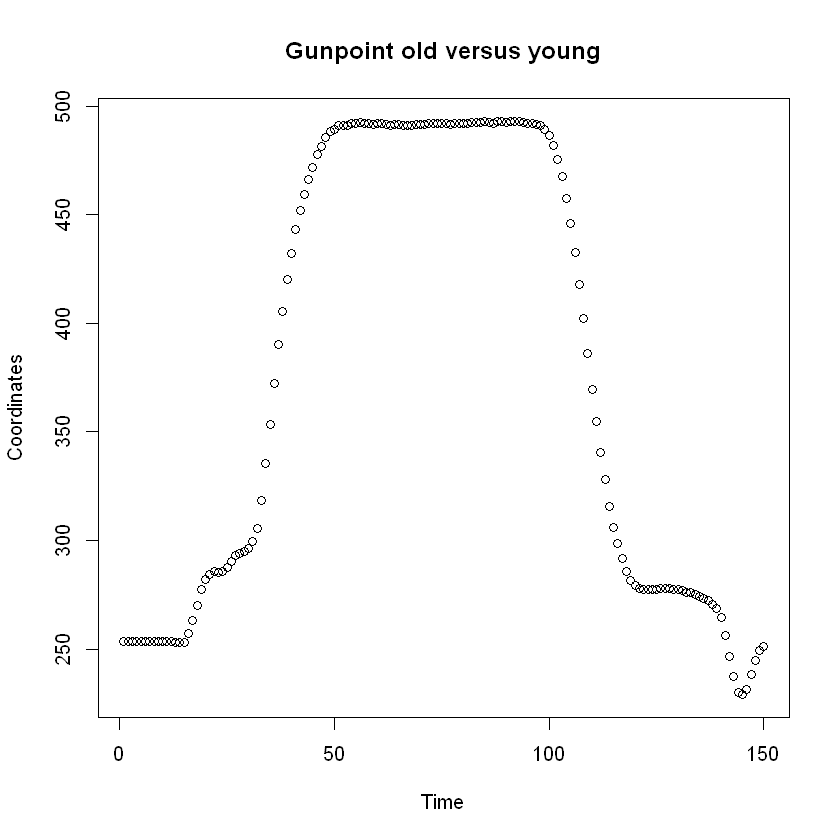

In [129]:
plot(x = long_gunpoint_train[id == 1 & class == 1]$time,y = long_gunpoint_train[id == 1 & class == 1]$value,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

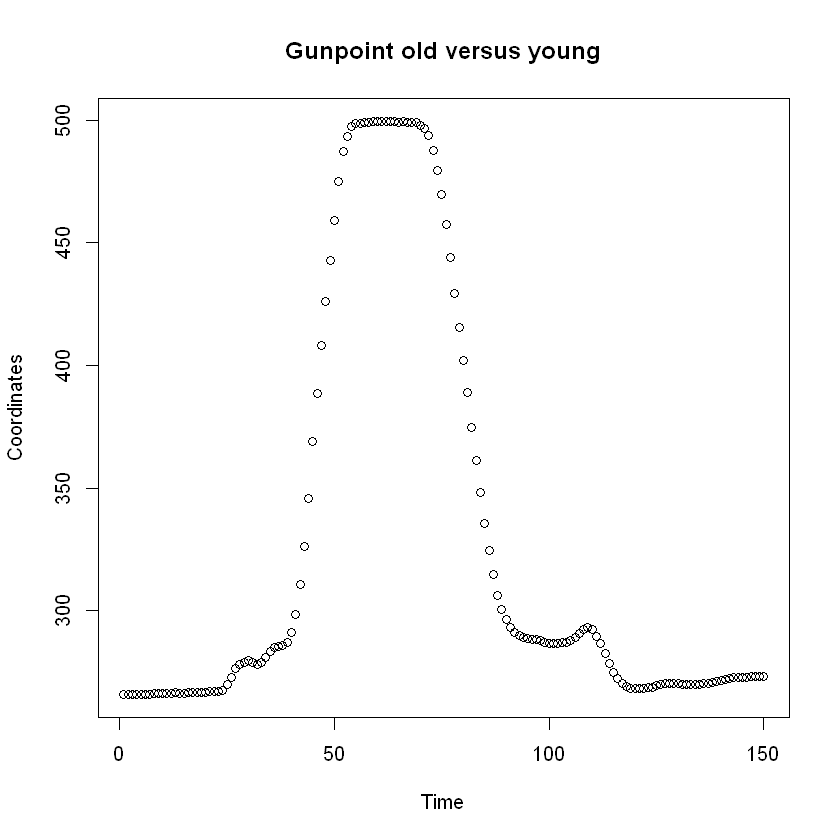

In [130]:
plot(x = long_gunpoint_train[id == 10 & class == 1]$time,y = long_gunpoint_train[id == 10 & class == 1]$value,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

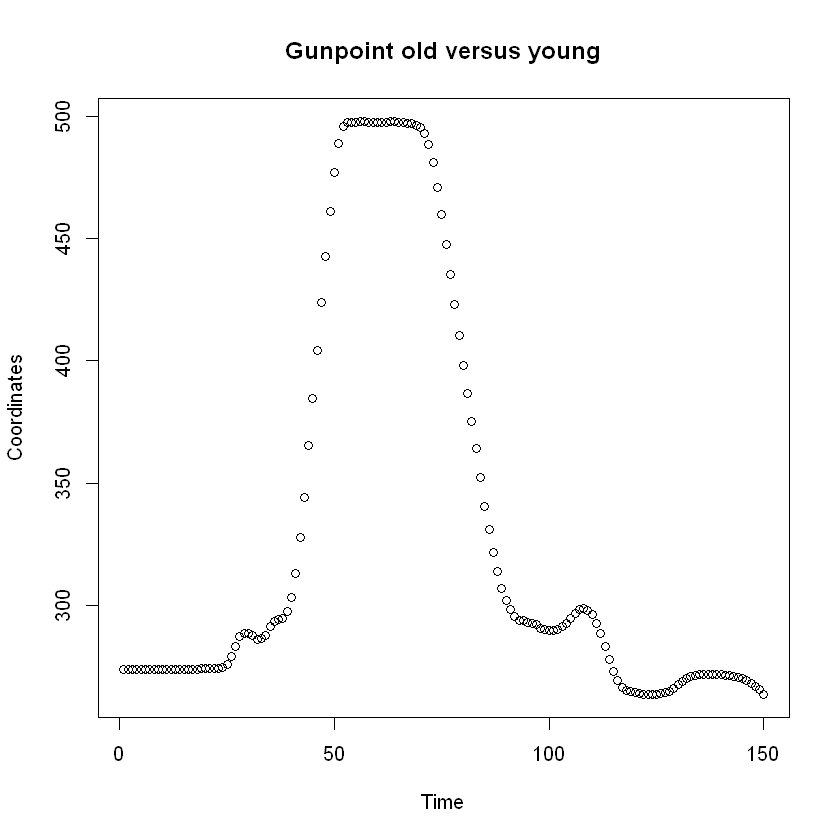

In [131]:
plot(x = long_gunpoint_train[id == 20 & class == 1]$time,y = long_gunpoint_train[id == 20 & class == 1]$value,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

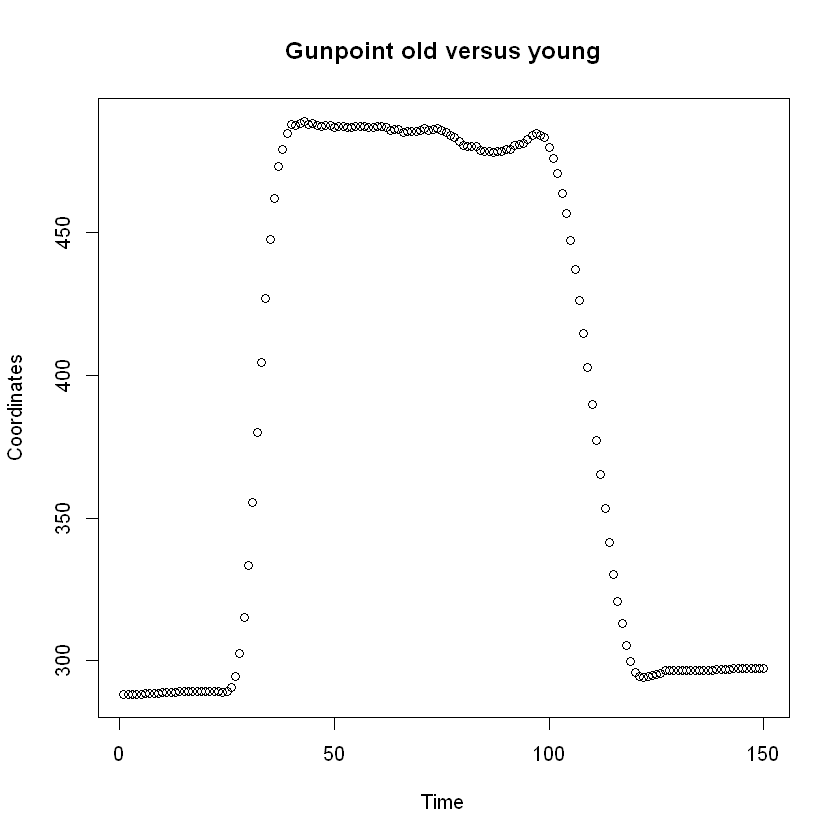

In [132]:
plot(x = long_gunpoint_train[id == 30 & class == 1]$time,y = long_gunpoint_train[id == 30 & class == 1]$value,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

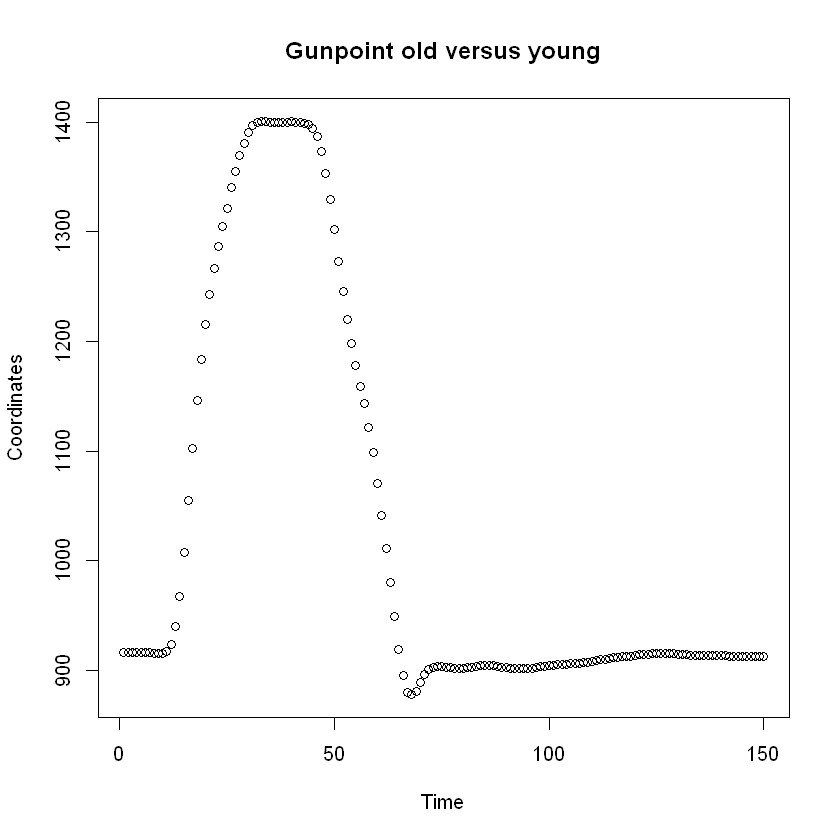

In [133]:
plot(x = long_gunpoint_train[id == 130 & class == 2]$time,y = long_gunpoint_train[id == 130 & class == 2]$value,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

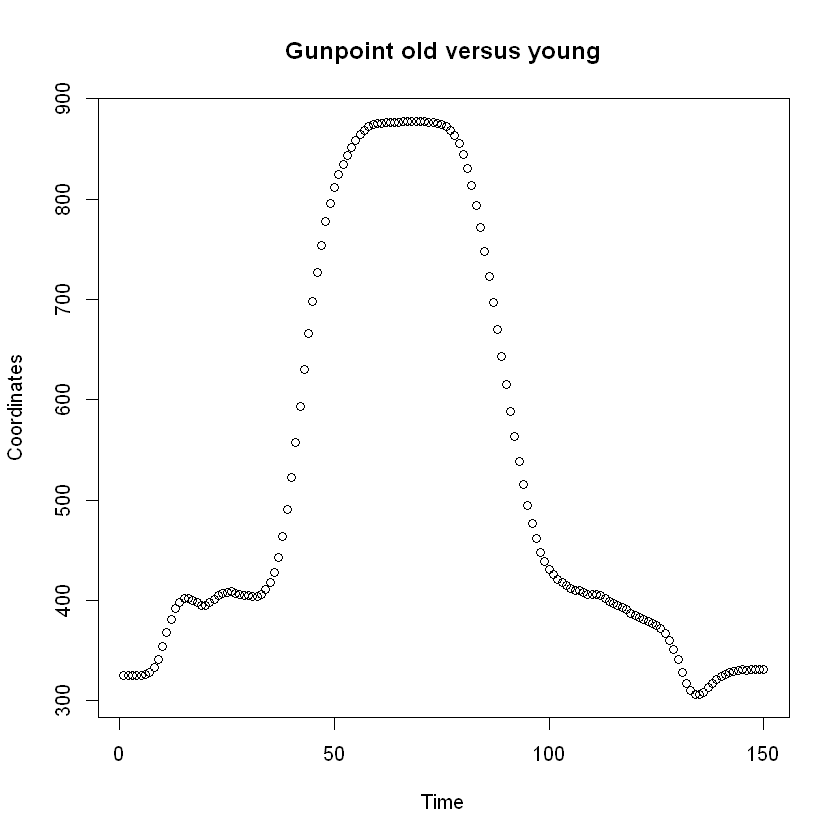

In [134]:
plot(x = long_gunpoint_train[id == 120 & class == 2]$time,y = long_gunpoint_train[id == 120 & class == 2]$value,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

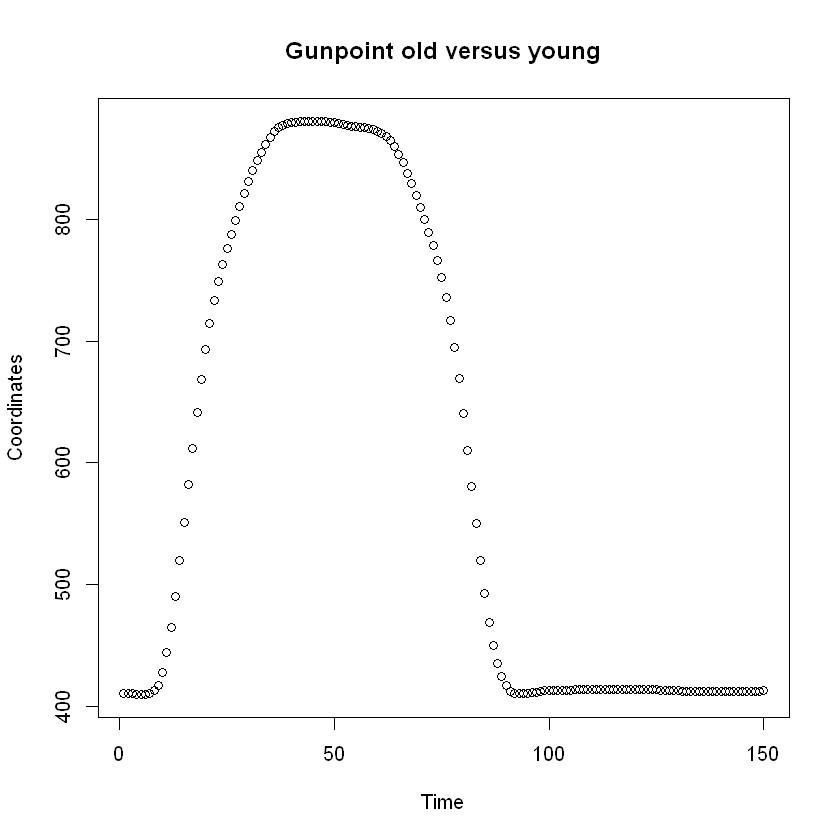

In [135]:
plot(x = long_gunpoint_train[id == 110 & class == 2]$time,y = long_gunpoint_train[id == 110 & class == 2]$value,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

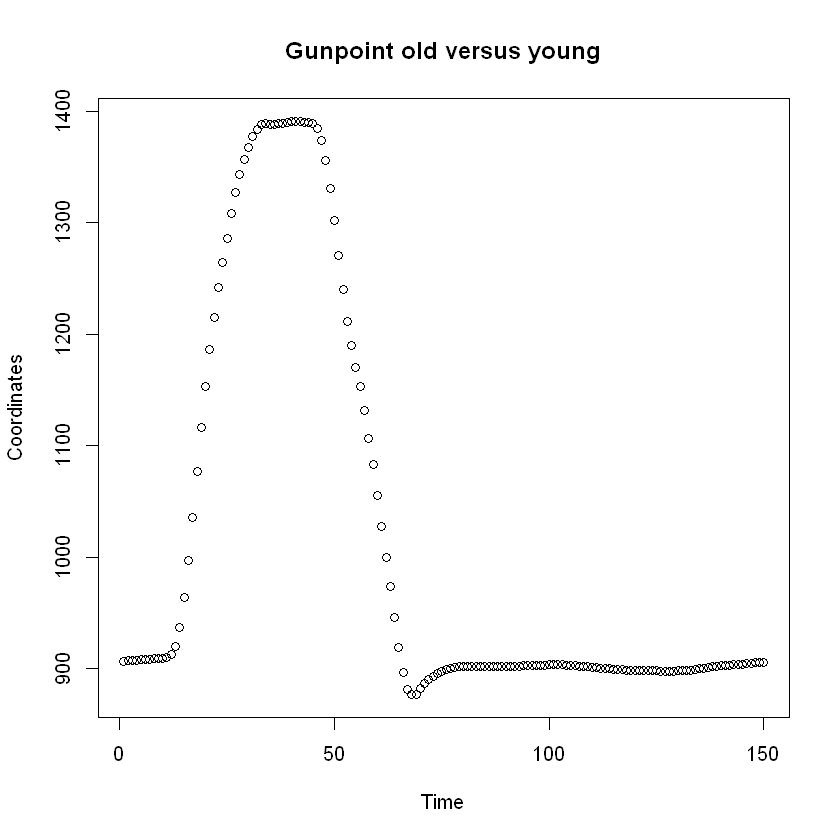

In [136]:
plot(x = long_gunpoint_train[id == 100 & class == 2]$time,y = long_gunpoint_train[id == 100 & class == 2]$value,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

In [14]:
# Tree Piecewise Representation
gunpoint_train = gunpoint_train[,2:(ncol(gunpoint_train)-1)]

Tree piecewise representation are done with maxdepth parameters 2,3 and 4.

In [15]:
for (i in 1:length(unique(long_gunpoint_train$id))){
tree_fit <- rpart(value~time,data = long_gunpoint_train[id == i],control = rpart.control(maxdepth = 2))
long_gunpoint_train[id == i,tree_piecewise_2:=predict(tree_fit,long_gunpoint_train[id == i])]
}

for (i in 1:length(unique(long_gunpoint_train$id))){
tree_fit <- rpart(value~time,data = long_gunpoint_train[id == i],control = rpart.control(maxdepth = 3))
long_gunpoint_train[id == i,tree_piecewise_3:=predict(tree_fit,long_gunpoint_train[id == i])]
}

for (i in 1:length(unique(long_gunpoint_train$id))){
tree_fit <- rpart(value~time,data = long_gunpoint_train[id == i],control = rpart.control(maxdepth = 4))
long_gunpoint_train[id == i,tree_piecewise_4:=predict(tree_fit,long_gunpoint_train[id == i])]
}

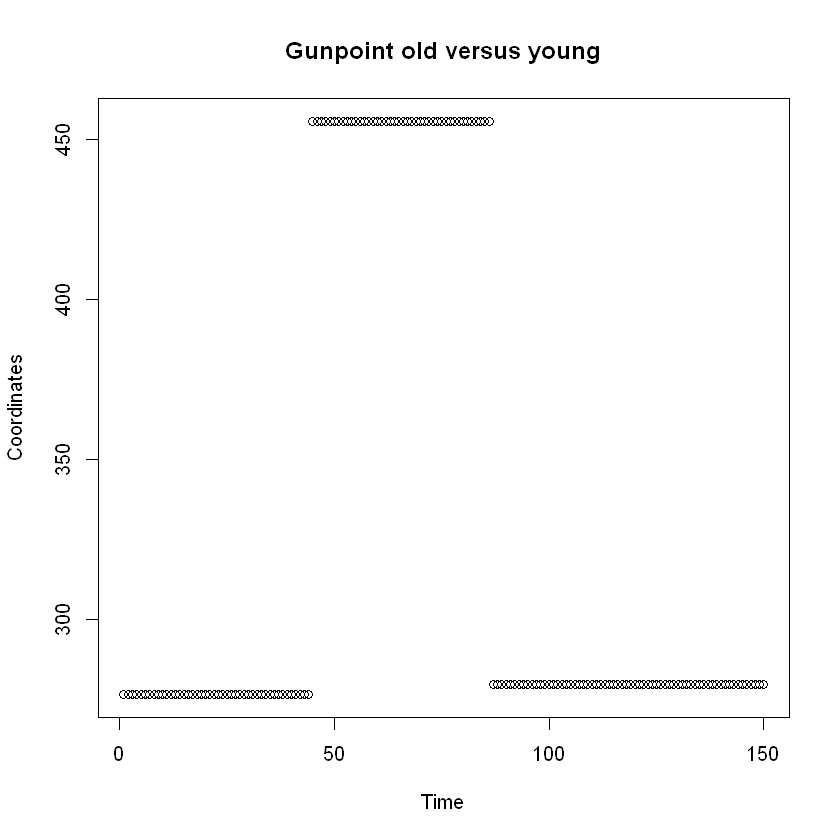

In [138]:
plot(x = long_gunpoint_train[id == 10 & class == 1]$time,y = long_gunpoint_train[id == 10 & class == 1]$tree_piecewise_2,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

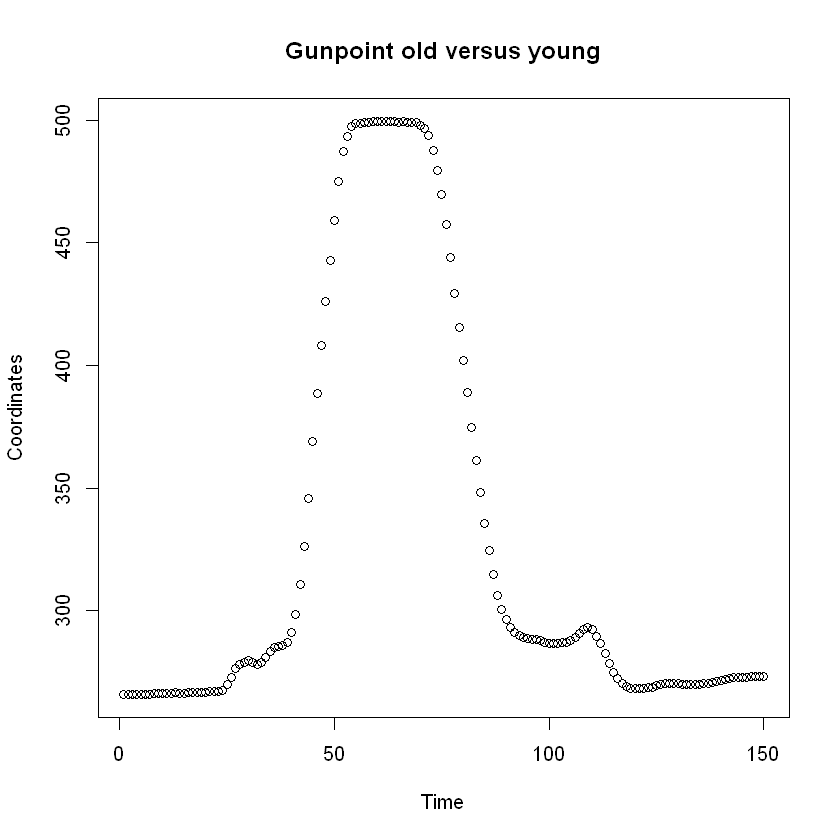

In [139]:
plot(x = long_gunpoint_train[id == 10 & class == 1]$time,y = long_gunpoint_train[id == 10 & class == 1]$value,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

Piecewise Aggregate Approximation representations are created with the segment length parameters 5, 10 and 20.

In [18]:
for (i in 1:length(unique(long_gunpoint_train$id))){
data_instance = long_gunpoint_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=5
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_gunpoint_train[id == i,"paa_reps_5"] = data_instance[,"paa_reps"]
}

for (i in 1:length(unique(long_gunpoint_train$id))){
data_instance = long_gunpoint_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=10
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_gunpoint_train[id == i,"paa_reps_10"] = data_instance[,"paa_reps"]
}

for (i in 1:length(unique(long_gunpoint_train$id))){
data_instance = long_gunpoint_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=20
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_gunpoint_train[id == i,"paa_reps_20"] = data_instance[,"paa_reps"]
}

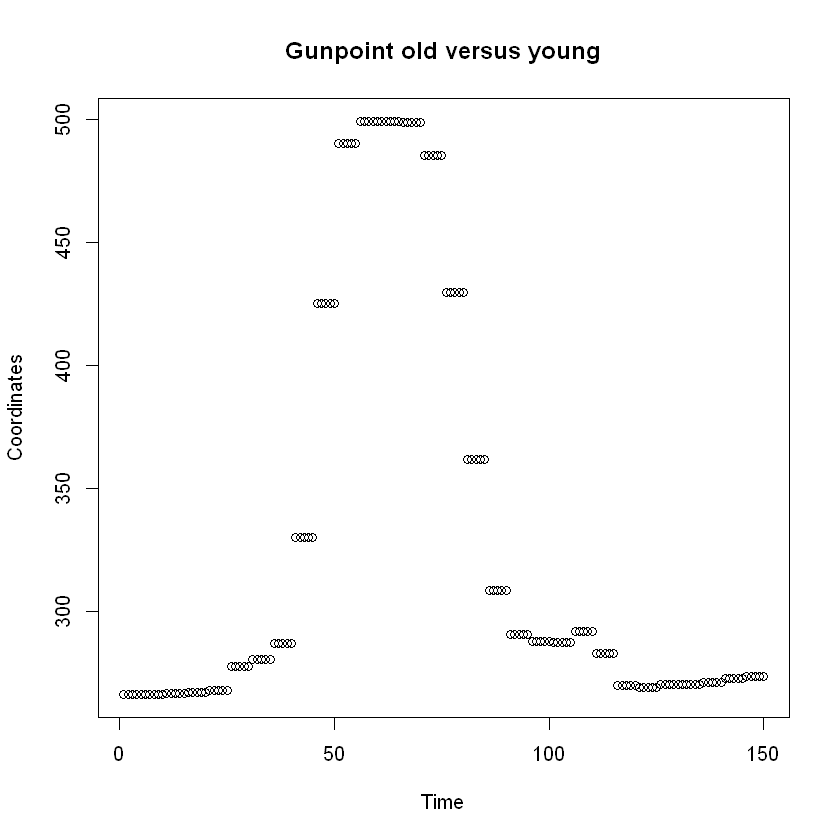

In [140]:
plot(x = long_gunpoint_train[id == 10 & class == 1]$time,y = long_gunpoint_train[id == 10 & class == 1]$paa_reps_5,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

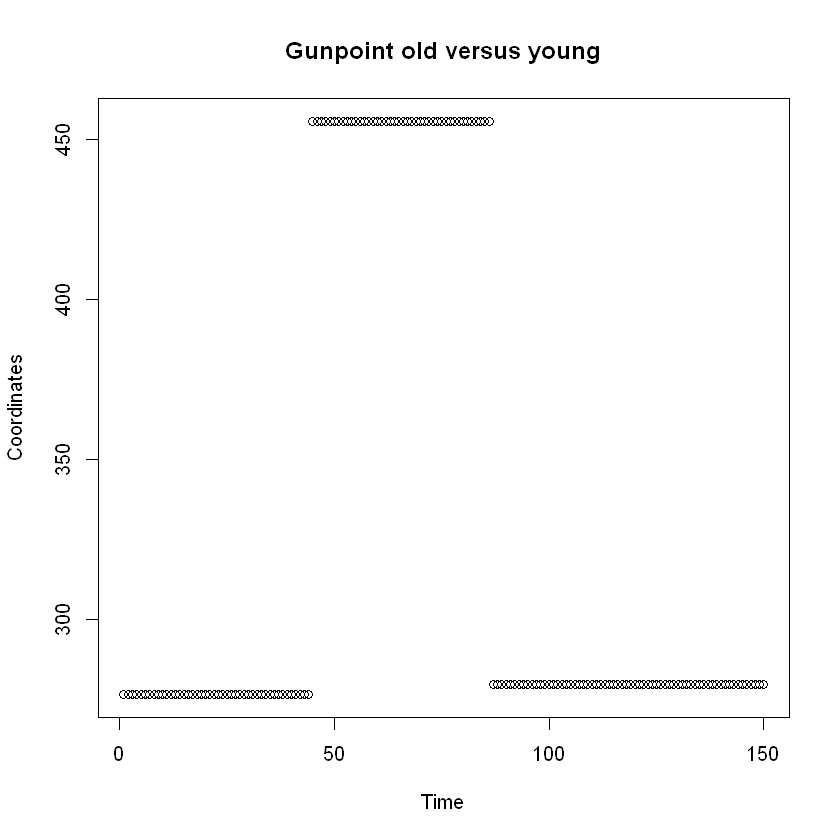

In [141]:
plot(x = long_gunpoint_train[id == 10 & class == 1]$time,y = long_gunpoint_train[id == 10 & class == 1]$tree_piecewise_2,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

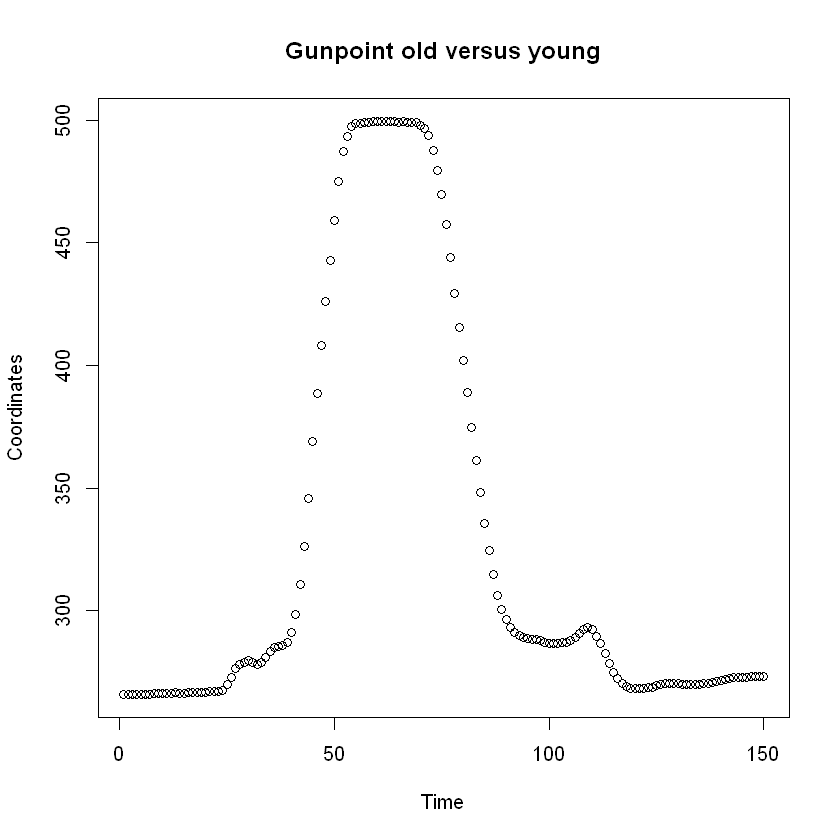

In [142]:
plot(x = long_gunpoint_train[id == 10 & class == 1]$time,y = long_gunpoint_train[id == 10 & class == 1]$value,
    xlab = "Time",ylab = "Coordinates",main = "Gunpoint old versus young")

Representations and raw dataset converted to matrix in order to calculate distance matrices

In [22]:
gunpoint_train_raw = data.frame()
for(i in 1:length(unique(long_gunpoint_train$id))){
gunpoint_train_raw = rbind(gunpoint_train_raw,t(as.data.frame(long_gunpoint_train[id == i]$value)))
}
row.names(gunpoint_train_raw) <- NULL

In [23]:
gunpoint_train_piecewise_2 = data.frame()
for(i in 1:length(unique(long_gunpoint_train$id))){
    gunpoint_train_piecewise_2 = rbind(gunpoint_train_piecewise_2,t(as.data.frame(long_gunpoint_train[id == i]$tree_piecewise_2)))
}

gunpoint_train_piecewise_3 = data.frame()
for(i in 1:length(unique(long_gunpoint_train$id))){
    gunpoint_train_piecewise_3 = rbind(gunpoint_train_piecewise_3,t(as.data.frame(long_gunpoint_train[id == i]$tree_piecewise_3)))
}

gunpoint_train_piecewise_4 = data.frame()
for(i in 1:length(unique(long_gunpoint_train$id))){
    gunpoint_train_piecewise_4 = rbind(gunpoint_train_piecewise_4,t(as.data.frame(long_gunpoint_train[id == i]$tree_piecewise_4)))
}
row.names(gunpoint_train_piecewise_2) <- NULL
row.names(gunpoint_train_piecewise_3) <- NULL
row.names(gunpoint_train_piecewise_4) <- NULL

In [24]:
gunpoint_train_paa_reps_5 = data.frame()
for(i in 1:length(unique(long_gunpoint_train$id))){
    gunpoint_train_paa_reps_5 = rbind(gunpoint_train_paa_reps_5,t(as.data.frame(long_gunpoint_train[id == i]$paa_reps_5)))
}

gunpoint_train_paa_reps_10 = data.frame()
for(i in 1:length(unique(long_gunpoint_train$id))){
    gunpoint_train_paa_reps_10 = rbind(gunpoint_train_paa_reps_10,t(as.data.frame(long_gunpoint_train[id == i]$paa_reps_10)))
}

gunpoint_train_paa_reps_20 = data.frame()
for(i in 1:length(unique(long_gunpoint_train$id))){
    gunpoint_train_paa_reps_20 = rbind(gunpoint_train_paa_reps_20,t(as.data.frame(long_gunpoint_train[id == i]$paa_reps_20)))
}
row.names(gunpoint_train_paa_reps_5) <- NULL
row.names(gunpoint_train_paa_reps_10) <- NULL
row.names(gunpoint_train_paa_reps_20) <- NULL

In [25]:
matrices = vector(mode = "list",length = 7)
matrices[[1]] = gunpoint_train_raw
matrices[[2]] = gunpoint_train_piecewise_2
matrices[[3]] = gunpoint_train_piecewise_3
matrices[[4]] = gunpoint_train_piecewise_4
matrices[[5]] = gunpoint_train_paa_reps_5
matrices[[6]] = gunpoint_train_paa_reps_10
matrices[[7]] = gunpoint_train_paa_reps_20

In [26]:
trainclass = c()
for(i in 1:length(unique(long_gunpoint_train$id))){
    trainclass = c(trainclass,unique(long_gunpoint_train[id==i,class]))
}

In [27]:
set.seed(500)
nof_rep=5
n_fold=10
cv_indices=generateCVRuns(trainclass, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

In [28]:
distances = vector(mode = "list",length = 7*4)

for(i in 1:7){
    large_number = 100000
    gunpoint_dist_euc=as.matrix(dist(matrices[[i]]))
    diag(gunpoint_dist_euc)=large_number

    gunpoint_dist_dtw=as.matrix(dtwDist(matrices[[i]]))
    diag(gunpoint_dist_dtw)=large_number

    gunpoint_dist_lcss=TSDatabaseDistances(matrices[[i]],distance='lcss',epsilon=0.05)
    gunpoint_dist_lcss=as.matrix(gunpoint_dist_lcss)
    diag(gunpoint_dist_lcss)=large_number 

    gunpoint_dist_manhattan=as.matrix(dist(matrices[[i]], method = "manhattan"))
    diag(gunpoint_dist_manhattan)=large_number
    
    distances[[1 + (i-1)*4]] = gunpoint_dist_euc
    distances[[2 + (i-1)*4]] = gunpoint_dist_dtw
    distances[[3 + (i-1)*4]] = gunpoint_dist_lcss
    distances[[4 + (i-1)*4]] = gunpoint_dist_manhattan
}


In [29]:
k_levels=c(1,3,5)
result=vector('list',length(distances)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(distances)){ #
    dist_mat = distances[[m]]
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass,test_indices,k=current_k)
                accuracy=sum(trainclass[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=paste("distance:",m),repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}

In [30]:
overall_results=rbindlist(result)
summarized_results=overall_results[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]

In [31]:
head(summarized_results[order(-avg_acc)])

approach,k,avg_acc,sdev_acc,result_count
<chr>,<dbl>,<dbl>,<dbl>,<int>
distance: 2,5,1,0,50
distance: 4,5,1,0,50
distance: 6,5,1,0,50
distance: 8,5,1,0,50
distance: 10,5,1,0,50
distance: 13,5,1,0,50


In [32]:
test_classes = gunpoint_test$V1
gunpoint_test = gunpoint_test[,2:ncol(gunpoint_test)]

In [33]:
gunpoint_dist_dtw_test=as.matrix(dtwDist(mx = gunpoint_test,my = matrices[[1]]))
diag(gunpoint_dist_dtw_test)=large_number

In [34]:
ordered_indices=apply(gunpoint_dist_dtw_test,1,order)
nearest_class=apply(ordered_indices[1:5,],2,function(x) {trainclass[x]})
nearest_class=data.table(id=1:nrow(gunpoint_test),t(nearest_class))
long_nn_class=melt(nearest_class,'id')
class_counts=long_nn_class[,.N,list(id,value)]
class_counts[,predicted_prob:=N/5]
wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]

table(test_classes,class_predictions$predicted)

acc=sum(test_classes==class_predictions$predicted)/length(class_predictions$predicted)
print(acc)

            
test_classes   1   2
           1 150   0
           2   0 165

[1] 1


# 2) PowerCons

The PowerCons dataset contains the individual household electric power consumption in one year distributed in two season classes: warm (class 1) and cold (class 2), depending on whether the power consumption is recorded during the warm seasons (from April to September) or the cold seasons (from October to March). Note that the electric power consumption profiles differ markedly within classes. The sampling rate is every ten-minute over a period of one year. Number of classes: 2 - Class 1: Warm season - Class 2: Cold season Missing value: No Source: EDF R&D, Clamart, France

In [35]:
powercons_train <- fread("PowerCons_TRAIN.txt")
powercons_test <- fread("PowerCons_TEST.txt")

setnames(powercons_train,"V1","class")
powercons_train=powercons_train[order(class)]
powercons_train[,class:=as.character(class)]
powercons_train[,id:=1:.N]
long_powercons_train=melt(powercons_train,id.vars=c('id','class'))
long_powercons_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_powercons_train=long_powercons_train[,list(id,class,time,value)]
long_powercons_train=long_powercons_train[order(id,time)]

powercons_train = powercons_train[,2:(ncol(powercons_train)-1)]

for (i in 1:length(unique(long_powercons_train$id))){
tree_fit <- rpart(value~time,data = long_powercons_train[id == i],control = rpart.control(maxdepth = 2))
long_powercons_train[id == i,tree_piecewise_2:=predict(tree_fit,long_powercons_train[id == i])]
}

for (i in 1:length(unique(long_powercons_train$id))){
tree_fit <- rpart(value~time,data = long_powercons_train[id == i],control = rpart.control(maxdepth = 3))
long_powercons_train[id == i,tree_piecewise_3:=predict(tree_fit,long_powercons_train[id == i])]
}

for (i in 1:length(unique(long_powercons_train$id))){
tree_fit <- rpart(value~time,data = long_powercons_train[id == i],control = rpart.control(maxdepth = 4))
long_powercons_train[id == i,tree_piecewise_4:=predict(tree_fit,long_powercons_train[id == i])]
}

for (i in 1:length(unique(long_powercons_train$id))){
data_instance = long_powercons_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=5
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_powercons_train[id == i,"paa_reps_5"] = data_instance[,"paa_reps"]
}

for (i in 1:length(unique(long_powercons_train$id))){
data_instance = long_powercons_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=10
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_powercons_train[id == i,"paa_reps_10"] = data_instance[,"paa_reps"]
}

for (i in 1:length(unique(long_powercons_train$id))){
data_instance = long_powercons_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=20
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_powercons_train[id == i,"paa_reps_20"] = data_instance[,"paa_reps"]
}


In [36]:
powercons_train_raw = data.frame()
for(i in 1:length(unique(long_powercons_train$id))){
powercons_train_raw = rbind(powercons_train_raw,t(as.data.frame(long_powercons_train[id == i]$value)))
}
row.names(powercons_train_raw) <- NULL

powercons_train_piecewise_2 = data.frame()
for(i in 1:length(unique(long_powercons_train$id))){
    powercons_train_piecewise_2 = rbind(powercons_train_piecewise_2,t(as.data.frame(long_powercons_train[id == i]$tree_piecewise_2)))
}

powercons_train_piecewise_3 = data.frame()
for(i in 1:length(unique(long_powercons_train$id))){
    powercons_train_piecewise_3 = rbind(powercons_train_piecewise_3,t(as.data.frame(long_powercons_train[id == i]$tree_piecewise_3)))
}

powercons_train_piecewise_4 = data.frame()
for(i in 1:length(unique(long_powercons_train$id))){
    powercons_train_piecewise_4 = rbind(powercons_train_piecewise_4,t(as.data.frame(long_powercons_train[id == i]$tree_piecewise_4)))
}
row.names(powercons_train_piecewise_2) <- NULL
row.names(powercons_train_piecewise_3) <- NULL
row.names(powercons_train_piecewise_4) <- NULL

powercons_train_paa_reps_5 = data.frame()
for(i in 1:length(unique(long_powercons_train$id))){
    powercons_train_paa_reps_5 = rbind(powercons_train_paa_reps_5,t(as.data.frame(long_powercons_train[id == i]$paa_reps_5)))
}

powercons_train_paa_reps_10 = data.frame()
for(i in 1:length(unique(long_powercons_train$id))){
    powercons_train_paa_reps_10 = rbind(powercons_train_paa_reps_10,t(as.data.frame(long_powercons_train[id == i]$paa_reps_10)))
}

powercons_train_paa_reps_20 = data.frame()
for(i in 1:length(unique(long_powercons_train$id))){
    powercons_train_paa_reps_20 = rbind(powercons_train_paa_reps_20,t(as.data.frame(long_powercons_train[id == i]$paa_reps_20)))
}
row.names(powercons_train_paa_reps_5) <- NULL
row.names(powercons_train_paa_reps_10) <- NULL
row.names(powercons_train_paa_reps_20) <- NULL

In [37]:
trainclass_powercons = c()
for(i in 1:length(unique(long_powercons_train$id))){
    trainclass_powercons = c(trainclass_powercons,unique(long_powercons_train[id==i,class]))
}

In [221]:
set.seed(500)
nof_rep=5
n_fold=10
cv_indices=generateCVRuns(trainclass_powercons, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

In [38]:
matrices_powercons = vector(mode = "list",length = 7)
matrices_powercons[[1]] = powercons_train_raw
matrices_powercons[[2]] = powercons_train_piecewise_2
matrices_powercons[[3]] = powercons_train_piecewise_3
matrices_powercons[[4]] = powercons_train_piecewise_4
matrices_powercons[[5]] = powercons_train_paa_reps_5
matrices_powercons[[6]] = powercons_train_paa_reps_10
matrices_powercons[[7]] = powercons_train_paa_reps_20

In [223]:
distances_powercons = vector(mode = "list",length = 7*4)

for(i in 1:7){
    large_number = 100000
    powercons_dist_euc=as.matrix(dist(matrices_powercons[[i]]))
    diag(powercons_dist_euc)=large_number

    powercons_dist_dtw=as.matrix(dtwDist(matrices_powercons[[i]]))
    diag(powercons_dist_dtw)=large_number

    powercons_dist_lcss=TSDatabaseDistances(matrices_powercons[[i]],distance='lcss',epsilon=0.05)
    powercons_dist_lcss=as.matrix(powercons_dist_lcss)
    diag(powercons_dist_lcss)=large_number 

    powercons_dist_manhattan=as.matrix(dist(matrices_powercons[[i]], method = "manhattan"))
    diag(powercons_dist_manhattan)=large_number
    
    distances_powercons[[1 + (i-1)*4]] = powercons_dist_euc
    distances_powercons[[2 + (i-1)*4]] = powercons_dist_dtw
    distances_powercons[[3 + (i-1)*4]] = powercons_dist_lcss
    distances_powercons[[4 + (i-1)*4]] = powercons_dist_manhattan
}


In [224]:
k_levels=c(1,3,5)
result=vector('list',length(distances_powercons)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(distances_powercons)){ #
    dist_mat = distances_powercons[[m]]
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass_powercons,test_indices,k=current_k)
                accuracy=sum(trainclass_powercons[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=paste("distance:",m),repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}

In [225]:
overall_results=rbindlist(result)
summarized_results=overall_results[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]

In [226]:
head(summarized_results[order(-avg_acc)])

approach,k,avg_acc,sdev_acc,result_count
<chr>,<dbl>,<dbl>,<dbl>,<int>
distance: 7,1,0.5000000,0.00000000,50
distance: 7,3,0.5000000,0.00000000,50
distance: 7,5,0.5000000,0.00000000,50
distance: 11,1,0.4922222,0.02512253,50
distance: 15,1,0.4800000,0.04009311,50
distance: 11,3,0.4800000,0.04312088,50


In [39]:
test_classes_powercons = powercons_test$V1
powercons_test = powercons_test[,2:ncol(powercons_test)]

In [42]:
powercons_dist_lcss_test=TSDatabaseDistances(X = powercons_test,Y = matrices_powercons[[2]],distance='lcss',epsilon=0.05)
powercons_dist_lcss_test=as.matrix(powercons_dist_lcss_test)
diag(powercons_dist_lcss_test)=large_number 

In [120]:
ordered_indices=apply(powercons_dist_lcss_test,1,order)
#nearest_class=apply(t(ordered_indices[1,]),2,function(x) {trainclass_powercons[x]})
#nearest_class=data.table(id=1:nrow(powercons_test),t(nearest_class))
nearest_class=as.numeric(trainclass_powercons[as.numeric(ordered_indices[1,])])
nearest_class=data.table(id=1:nrow(powercons_test),nearest_class)
long_nn_class=melt(nearest_class,'id')
class_counts=long_nn_class[,.N,list(id,value)]
class_counts[,predicted_prob:=N/5]
wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]

table(test_classes_powercons,class_predictions$predicted)

acc=sum(test_classes_powercons==class_predictions$predicted)/length(class_predictions$predicted)
print(acc)

                      
test_classes_powercons  1  2
                     1 17 73
                     2 31 59

[1] 0.4222222


In [119]:
t(ordered_indices[1,])

101,101,101,101,101,118,110,133,101,118,...,101,70,8,101,122,118,134,72,118,70


# 3) FreezerRegularTrain

The collection of this data was part of the project titled Personalised Retrofit Decision Support Tools for UK Homes using Smart Home Technology (REFIT). The REFIT dataset includes data from 20 households from Loughborough area over the period 2013-2014 (see [1], [2]). We use data of freezers in House 1 to make two datasets. These two datasets share a same test set and only differ in the number of training instances. There is nothing to infer from the order of examples in the train and test set Data created by David Murray et al. (see [2]). Data edited by Shaghayegh Gharghabi, Hoang Anh Dau and Eamonn Keogh. [1] (Link Here) [2] Murray, David et al., "A data management platform for personalised real-time energy feedback", Proceedings of the 8th International Conference on Engery Efficiency in Domestic Appliances and Lighting, 2015. There are two classes, one representing the power demand of the fridge freezer in the kitchen, the other representing the power demand of the (less frequently used) freezer in the garage. They are hard to tell apart globally but they differ locally.

In [48]:
FreezerRegularTrain_train <- fread("FreezerRegularTrain_TRAIN.txt")
FreezerRegularTrain_test <- fread("FreezerRegularTrain_TEST.txt")

setnames(FreezerRegularTrain_train,"V1","class")
FreezerRegularTrain_train=FreezerRegularTrain_train[order(class)]
FreezerRegularTrain_train[,class:=as.character(class)]
FreezerRegularTrain_train[,id:=1:.N]
long_FreezerRegularTrain_train=melt(FreezerRegularTrain_train,id.vars=c('id','class'))
long_FreezerRegularTrain_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_FreezerRegularTrain_train=long_FreezerRegularTrain_train[,list(id,class,time,value)]
long_FreezerRegularTrain_train=long_FreezerRegularTrain_train[order(id,time)]

FreezerRegularTrain_train = FreezerRegularTrain_train[,2:(ncol(FreezerRegularTrain_train)-1)]

for (i in 1:length(unique(long_FreezerRegularTrain_train$id))){
tree_fit <- rpart(value~time,data = long_FreezerRegularTrain_train[id == i],control = rpart.control(maxdepth = 2))
long_FreezerRegularTrain_train[id == i,tree_piecewise_2:=predict(tree_fit,long_FreezerRegularTrain_train[id == i])]
}

for (i in 1:length(unique(long_FreezerRegularTrain_train$id))){
tree_fit <- rpart(value~time,data = long_FreezerRegularTrain_train[id == i],control = rpart.control(maxdepth = 3))
long_FreezerRegularTrain_train[id == i,tree_piecewise_3:=predict(tree_fit,long_FreezerRegularTrain_train[id == i])]
}

for (i in 1:length(unique(long_FreezerRegularTrain_train$id))){
tree_fit <- rpart(value~time,data = long_FreezerRegularTrain_train[id == i],control = rpart.control(maxdepth = 4))
long_FreezerRegularTrain_train[id == i,tree_piecewise_4:=predict(tree_fit,long_FreezerRegularTrain_train[id == i])]
}

for (i in 1:length(unique(long_FreezerRegularTrain_train$id))){
data_instance = long_FreezerRegularTrain_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=5
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_FreezerRegularTrain_train[id == i,"paa_reps_5"] = data_instance[,"paa_reps"]
}

for (i in 1:length(unique(long_FreezerRegularTrain_train$id))){
data_instance = long_FreezerRegularTrain_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=10
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_FreezerRegularTrain_train[id == i,"paa_reps_10"] = data_instance[,"paa_reps"]
}

for (i in 1:length(unique(long_FreezerRegularTrain_train$id))){
data_instance = long_FreezerRegularTrain_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=20
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_FreezerRegularTrain_train[id == i,"paa_reps_20"] = data_instance[,"paa_reps"]
}
    
FreezerRegularTrain_train_raw = data.frame()
for(i in 1:length(unique(long_FreezerRegularTrain_train$id))){
FreezerRegularTrain_train_raw = rbind(FreezerRegularTrain_train_raw,t(as.data.frame(long_FreezerRegularTrain_train[id == i]$value)))
}
row.names(FreezerRegularTrain_train_raw) <- NULL

FreezerRegularTrain_train_piecewise_2 = data.frame()
for(i in 1:length(unique(long_FreezerRegularTrain_train$id))){
    FreezerRegularTrain_train_piecewise_2 = rbind(FreezerRegularTrain_train_piecewise_2,t(as.data.frame(long_FreezerRegularTrain_train[id == i]$tree_piecewise_2)))
}

FreezerRegularTrain_train_piecewise_3 = data.frame()
for(i in 1:length(unique(long_FreezerRegularTrain_train$id))){
    FreezerRegularTrain_train_piecewise_3 = rbind(FreezerRegularTrain_train_piecewise_3,t(as.data.frame(long_FreezerRegularTrain_train[id == i]$tree_piecewise_3)))
}

FreezerRegularTrain_train_piecewise_4 = data.frame()
for(i in 1:length(unique(long_FreezerRegularTrain_train$id))){
    FreezerRegularTrain_train_piecewise_4 = rbind(FreezerRegularTrain_train_piecewise_4,t(as.data.frame(long_FreezerRegularTrain_train[id == i]$tree_piecewise_4)))
}
row.names(FreezerRegularTrain_train_piecewise_2) <- NULL
row.names(FreezerRegularTrain_train_piecewise_3) <- NULL
row.names(FreezerRegularTrain_train_piecewise_4) <- NULL

FreezerRegularTrain_train_paa_reps_5 = data.frame()
for(i in 1:length(unique(long_FreezerRegularTrain_train$id))){
    FreezerRegularTrain_train_paa_reps_5 = rbind(FreezerRegularTrain_train_paa_reps_5,t(as.data.frame(long_FreezerRegularTrain_train[id == i]$paa_reps_5)))
}

FreezerRegularTrain_train_paa_reps_10 = data.frame()
for(i in 1:length(unique(long_FreezerRegularTrain_train$id))){
    FreezerRegularTrain_train_paa_reps_10 = rbind(FreezerRegularTrain_train_paa_reps_10,t(as.data.frame(long_FreezerRegularTrain_train[id == i]$paa_reps_10)))
}

FreezerRegularTrain_train_paa_reps_20 = data.frame()
for(i in 1:length(unique(long_FreezerRegularTrain_train$id))){
    FreezerRegularTrain_train_paa_reps_20 = rbind(FreezerRegularTrain_train_paa_reps_20,t(as.data.frame(long_FreezerRegularTrain_train[id == i]$paa_reps_20)))
}
row.names(FreezerRegularTrain_train_paa_reps_5) <- NULL
row.names(FreezerRegularTrain_train_paa_reps_10) <- NULL
row.names(FreezerRegularTrain_train_paa_reps_20) <- NULL
    
trainclass_FreezerRegularTrain = c()
for(i in 1:length(unique(long_FreezerRegularTrain_train$id))){
    trainclass_FreezerRegularTrain = c(trainclass_FreezerRegularTrain,unique(long_FreezerRegularTrain_train[id==i,class]))
}

set.seed(500)
nof_rep=5
n_fold=10
cv_indices=generateCVRuns(trainclass_FreezerRegularTrain, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

matrices_FreezerRegularTrain = vector(mode = "list",length = 7)
matrices_FreezerRegularTrain[[1]] = FreezerRegularTrain_train_raw
matrices_FreezerRegularTrain[[2]] = FreezerRegularTrain_train_piecewise_2
matrices_FreezerRegularTrain[[3]] = FreezerRegularTrain_train_piecewise_3
matrices_FreezerRegularTrain[[4]] = FreezerRegularTrain_train_piecewise_4
matrices_FreezerRegularTrain[[5]] = FreezerRegularTrain_train_paa_reps_5
matrices_FreezerRegularTrain[[6]] = FreezerRegularTrain_train_paa_reps_10
matrices_FreezerRegularTrain[[7]] = FreezerRegularTrain_train_paa_reps_20
    
distances_FreezerRegularTrain = vector(mode = "list",length = 7*4)

for(i in 1:7){
    large_number = 100000
    FreezerRegularTrain_dist_euc=as.matrix(dist(matrices_FreezerRegularTrain[[i]]))
    diag(FreezerRegularTrain_dist_euc)=large_number

    FreezerRegularTrain_dist_dtw=as.matrix(dtwDist(matrices_FreezerRegularTrain[[i]]))
    diag(FreezerRegularTrain_dist_dtw)=large_number

    FreezerRegularTrain_dist_lcss=TSDatabaseDistances(matrices_FreezerRegularTrain[[i]],distance='lcss',epsilon=0.05)
    FreezerRegularTrain_dist_lcss=as.matrix(FreezerRegularTrain_dist_lcss)
    diag(FreezerRegularTrain_dist_lcss)=large_number 

    FreezerRegularTrain_dist_manhattan=as.matrix(dist(matrices_FreezerRegularTrain[[i]], method = "manhattan"))
    diag(FreezerRegularTrain_dist_manhattan)=large_number
    
    distances_FreezerRegularTrain[[1 + (i-1)*4]] = FreezerRegularTrain_dist_euc
    distances_FreezerRegularTrain[[2 + (i-1)*4]] = FreezerRegularTrain_dist_dtw
    distances_FreezerRegularTrain[[3 + (i-1)*4]] = FreezerRegularTrain_dist_lcss
    distances_FreezerRegularTrain[[4 + (i-1)*4]] = FreezerRegularTrain_dist_manhattan
}

k_levels=c(1,3,5)
result=vector('list',length(distances_FreezerRegularTrain)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(distances_FreezerRegularTrain)){ #
    dist_mat = distances_FreezerRegularTrain[[m]]
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass_FreezerRegularTrain,test_indices,k=current_k)
                accuracy=sum(trainclass_FreezerRegularTrain[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=paste("distance:",m),repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}

overall_results=rbindlist(result)
summarized_results=overall_results[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]



In [49]:
head(summarized_results[order(-avg_acc)])

approach,k,avg_acc,sdev_acc,result_count
<chr>,<dbl>,<dbl>,<dbl>,<int>
distance: 20,1,0.9013333,0.07765264,50
distance: 24,1,0.8973333,0.07153643,50
distance: 28,1,0.8946667,0.07388169,50
distance: 4,1,0.8920000,0.06853173,50
distance: 26,1,0.8813333,0.07534050,50
distance: 21,1,0.8720000,0.08393929,50


In [50]:
test_classes_FreezerRegularTrain = FreezerRegularTrain_test$V1
FreezerRegularTrain_test = FreezerRegularTrain_test[,2:ncol(FreezerRegularTrain_test)]

In [53]:
FreezerRegularTrain_dist_manhattan_test=as.matrix(dist(x = FreezerRegularTrain_test, y = matrices_FreezerRegularTrain[[5]], method = "manhattan"))
diag(FreezerRegularTrain_dist_manhattan_test)=large_number

In [121]:
ordered_indices=apply(FreezerRegularTrain_dist_manhattan_test,1,order)
#nearest_class=apply(as.matrix(ordered_indices[1,],2,function(x) {trainclass_FreezerRegularTrain[x]})
#nearest_class=data.table(id=1:nrow(FreezerRegularTrain_test),t(nearest_class))
nearest_class=as.numeric(trainclass_FreezerRegularTrain[as.numeric(ordered_indices[1,])])
nearest_class=data.table(id=1:nrow(FreezerRegularTrain_test),nearest_class)
long_nn_class=melt(nearest_class,'id')
class_counts=long_nn_class[,.N,list(id,value)]
class_counts[,predicted_prob:=N/3]
wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]

table(test_classes_FreezerRegularTrain,class_predictions$predicted)

acc=sum(test_classes_FreezerRegularTrain==class_predictions$predicted)/length(class_predictions$predicted)
print(acc)

                                
test_classes_FreezerRegularTrain    1    2
                               1 1363   62
                               2  148 1277

[1] 0.9263158


# 4) Ham

Food spectrographs are used in chemometrics to classify food types, a task that has obvious applications in food safety and quality assurance. The ham data includes measurements from 19 Spanish and 18 French dry-cured hams. Triplicate lanes of duplicate extractions (giving ~6 data vectors per sample), pre-processed and aligned as described in �Sodium dodecyl sulphate-polyacrylamide gel electrophoresis of proteins in dry-cured hams: Data registration and multivariate analysis across multiple gels�, Olias R. et. al., Electrophoresis 27 (7) 1288-1299.

In [58]:
Ham_train <- fread("Ham_TRAIN.txt")
Ham_test <- fread("Ham_TEST.txt")

setnames(Ham_train,"V1","class")
Ham_train=Ham_train[order(class)]
Ham_train[,class:=as.character(class)]
Ham_train[,id:=1:.N]
long_Ham_train=melt(Ham_train,id.vars=c('id','class'))
long_Ham_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_Ham_train=long_Ham_train[,list(id,class,time,value)]
long_Ham_train=long_Ham_train[order(id,time)]

Ham_train = Ham_train[,2:(ncol(Ham_train)-1)]

for (i in 1:length(unique(long_Ham_train$id))){
tree_fit <- rpart(value~time,data = long_Ham_train[id == i],control = rpart.control(maxdepth = 2))
long_Ham_train[id == i,tree_piecewise_2:=predict(tree_fit,long_Ham_train[id == i])]
}

for (i in 1:length(unique(long_Ham_train$id))){
tree_fit <- rpart(value~time,data = long_Ham_train[id == i],control = rpart.control(maxdepth = 3))
long_Ham_train[id == i,tree_piecewise_3:=predict(tree_fit,long_Ham_train[id == i])]
}

for (i in 1:length(unique(long_Ham_train$id))){
tree_fit <- rpart(value~time,data = long_Ham_train[id == i],control = rpart.control(maxdepth = 4))
long_Ham_train[id == i,tree_piecewise_4:=predict(tree_fit,long_Ham_train[id == i])]
}

for (i in 1:length(unique(long_Ham_train$id))){
data_instance = long_Ham_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=5
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_Ham_train[id == i,"paa_reps_5"] = data_instance[,"paa_reps"]
}

for (i in 1:length(unique(long_Ham_train$id))){
data_instance = long_Ham_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=10
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_Ham_train[id == i,"paa_reps_10"] = data_instance[,"paa_reps"]
}

for (i in 1:length(unique(long_Ham_train$id))){
data_instance = long_Ham_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=20
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_Ham_train[id == i,"paa_reps_20"] = data_instance[,"paa_reps"]
}
    
Ham_train_raw = data.frame()
for(i in 1:length(unique(long_Ham_train$id))){
Ham_train_raw = rbind(Ham_train_raw,t(as.data.frame(long_Ham_train[id == i]$value)))
}
row.names(Ham_train_raw) <- NULL

Ham_train_piecewise_2 = data.frame()
for(i in 1:length(unique(long_Ham_train$id))){
    Ham_train_piecewise_2 = rbind(Ham_train_piecewise_2,t(as.data.frame(long_Ham_train[id == i]$tree_piecewise_2)))
}

Ham_train_piecewise_3 = data.frame()
for(i in 1:length(unique(long_Ham_train$id))){
    Ham_train_piecewise_3 = rbind(Ham_train_piecewise_3,t(as.data.frame(long_Ham_train[id == i]$tree_piecewise_3)))
}

Ham_train_piecewise_4 = data.frame()
for(i in 1:length(unique(long_Ham_train$id))){
    Ham_train_piecewise_4 = rbind(Ham_train_piecewise_4,t(as.data.frame(long_Ham_train[id == i]$tree_piecewise_4)))
}
row.names(Ham_train_piecewise_2) <- NULL
row.names(Ham_train_piecewise_3) <- NULL
row.names(Ham_train_piecewise_4) <- NULL

Ham_train_paa_reps_5 = data.frame()
for(i in 1:length(unique(long_Ham_train$id))){
    Ham_train_paa_reps_5 = rbind(Ham_train_paa_reps_5,t(as.data.frame(long_Ham_train[id == i]$paa_reps_5)))
}

Ham_train_paa_reps_10 = data.frame()
for(i in 1:length(unique(long_Ham_train$id))){
    Ham_train_paa_reps_10 = rbind(Ham_train_paa_reps_10,t(as.data.frame(long_Ham_train[id == i]$paa_reps_10)))
}

Ham_train_paa_reps_20 = data.frame()
for(i in 1:length(unique(long_Ham_train$id))){
    Ham_train_paa_reps_20 = rbind(Ham_train_paa_reps_20,t(as.data.frame(long_Ham_train[id == i]$paa_reps_20)))
}
row.names(Ham_train_paa_reps_5) <- NULL
row.names(Ham_train_paa_reps_10) <- NULL
row.names(Ham_train_paa_reps_20) <- NULL
    
trainclass_Ham = c()
for(i in 1:length(unique(long_Ham_train$id))){
    trainclass_Ham = c(trainclass_Ham,unique(long_Ham_train[id==i,class]))
}

set.seed(500)
nof_rep=5
n_fold=10
cv_indices=generateCVRuns(trainclass_Ham, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

matrices_Ham = vector(mode = "list",length = 7)
matrices_Ham[[1]] = Ham_train_raw
matrices_Ham[[2]] = Ham_train_piecewise_2
matrices_Ham[[3]] = Ham_train_piecewise_3
matrices_Ham[[4]] = Ham_train_piecewise_4
matrices_Ham[[5]] = Ham_train_paa_reps_5
matrices_Ham[[6]] = Ham_train_paa_reps_10
matrices_Ham[[7]] = Ham_train_paa_reps_20
    
distances_Ham = vector(mode = "list",length = 7*4)

for(i in 1:7){
    large_number = 100000
    Ham_dist_euc=as.matrix(dist(matrices_Ham[[i]]))
    diag(Ham_dist_euc)=large_number

    Ham_dist_dtw=as.matrix(dtwDist(matrices_Ham[[i]]))
    diag(Ham_dist_dtw)=large_number

    Ham_dist_lcss=TSDatabaseDistances(matrices_Ham[[i]],distance='lcss',epsilon=0.05)
    Ham_dist_lcss=as.matrix(Ham_dist_lcss)
    diag(Ham_dist_lcss)=large_number 

    Ham_dist_manhattan=as.matrix(dist(matrices_Ham[[i]], method = "manhattan"))
    diag(Ham_dist_manhattan)=large_number
    
    distances_Ham[[1 + (i-1)*4]] = Ham_dist_euc
    distances_Ham[[2 + (i-1)*4]] = Ham_dist_dtw
    distances_Ham[[3 + (i-1)*4]] = Ham_dist_lcss
    distances_Ham[[4 + (i-1)*4]] = Ham_dist_manhattan
}

k_levels=c(1,3,5)
result=vector('list',length(distances_Ham)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(distances_Ham)){ #
    dist_mat = distances_Ham[[m]]
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass_Ham,test_indices,k=current_k)
                accuracy=sum(trainclass_Ham[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=paste("distance:",m),repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}

overall_results=rbindlist(result)
summarized_results=overall_results[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]



In [59]:
head(summarized_results[order(-avg_acc)],10)

approach,k,avg_acc,sdev_acc,result_count
<chr>,<dbl>,<dbl>,<dbl>,<int>
distance: 20,1,0.7854545,0.1155333,50
distance: 4,3,0.7778182,0.1094792,50
distance: 4,1,0.7743636,0.1260703,50
distance: 28,1,0.7618182,0.1424078,50
distance: 17,1,0.7598182,0.1003131,50
distance: 20,3,0.7592727,0.1032650,50
distance: 1,1,0.7554545,0.1347054,50
distance: 24,1,0.7394545,0.1146336,50
distance: 25,1,0.7334545,0.1355441,50


In [60]:
test_classes_Ham = Ham_test$V1
Ham_test = Ham_test[,2:ncol(Ham_test)]

In [61]:
Ham_dist_manhattan_test=as.matrix(dist(x = Ham_test, y = matrices_Ham[[5]], method = "manhattan"))
diag(Ham_dist_manhattan_test)=large_number

In [125]:
ordered_indices=apply(Ham_dist_manhattan_test,1,order)
#nearest_class=apply(ordered_indices[1:5,],2,function(x) {trainclass_Ham[x]})
#nearest_class=data.table(id=1:nrow(Ham_test),t(nearest_class))
nearest_class=as.numeric(trainclass_Ham[as.numeric(ordered_indices[1,])])
nearest_class=data.table(id=1:nrow(Ham_test),nearest_class)
long_nn_class=melt(nearest_class,'id')
class_counts=long_nn_class[,.N,list(id,value)]
class_counts[,predicted_prob:=N/1]
wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]

table(test_classes_Ham,class_predictions$predicted)

acc=sum(test_classes_Ham==class_predictions$predicted)/length(class_predictions$predicted)
print(acc)

                
test_classes_Ham  1  2
               1 27 24
               2 27 27

[1] 0.5142857


# 5) ECG200

This dataset was formatted by R. Olszewski as part of his thesis "Generalized feature extraction for structural pattern recognition in time-series data" at Carnegie Mellon University, 2001. Each series traces the electrical activity recorded during one heartbeat. The two classes are a normal heartbeat and a Myocardial Infarction.

In [63]:
ECG200_train <- fread("ECG200_TRAIN.txt")
ECG200_test <- fread("ECG200_TEST.txt")

setnames(ECG200_train,"V1","class")
ECG200_train=ECG200_train[order(class)]
ECG200_train[,class:=as.character(class)]
ECG200_train[,id:=1:.N]
long_ECG200_train=melt(ECG200_train,id.vars=c('id','class'))
long_ECG200_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_ECG200_train=long_ECG200_train[,list(id,class,time,value)]
long_ECG200_train=long_ECG200_train[order(id,time)]

ECG200_train = ECG200_train[,2:(ncol(ECG200_train)-1)]

for (i in 1:length(unique(long_ECG200_train$id))){
tree_fit <- rpart(value~time,data = long_ECG200_train[id == i],control = rpart.control(maxdepth = 2))
long_ECG200_train[id == i,tree_piecewise_2:=predict(tree_fit,long_ECG200_train[id == i])]
}

for (i in 1:length(unique(long_ECG200_train$id))){
tree_fit <- rpart(value~time,data = long_ECG200_train[id == i],control = rpart.control(maxdepth = 3))
long_ECG200_train[id == i,tree_piecewise_3:=predict(tree_fit,long_ECG200_train[id == i])]
}

for (i in 1:length(unique(long_ECG200_train$id))){
tree_fit <- rpart(value~time,data = long_ECG200_train[id == i],control = rpart.control(maxdepth = 4))
long_ECG200_train[id == i,tree_piecewise_4:=predict(tree_fit,long_ECG200_train[id == i])]
}

for (i in 1:length(unique(long_ECG200_train$id))){
data_instance = long_ECG200_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=5
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_ECG200_train[id == i,"paa_reps_5"] = data_instance[,"paa_reps"]
}

for (i in 1:length(unique(long_ECG200_train$id))){
data_instance = long_ECG200_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=10
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_ECG200_train[id == i,"paa_reps_10"] = data_instance[,"paa_reps"]
}

for (i in 1:length(unique(long_ECG200_train$id))){
data_instance = long_ECG200_train[id == i]
#data_instance[,paa_reps:=NULL]
segment_length=20
paa_reps=repr_paa(data_instance$value, segment_length, meanC)
dummy_time=c(1:(length(paa_reps)-1))*segment_length 
dummy_time=c(dummy_time,nrow(data_instance))
dt_paa=data.table(time=dummy_time,paa_reps=paa_reps)
data_instance=merge(data_instance,dt_paa,by='time',all.x=T)
data_instance[,paa_reps:=nafill(paa_reps,'nocb')]
long_ECG200_train[id == i,"paa_reps_20"] = data_instance[,"paa_reps"]
}
    
ECG200_train_raw = data.frame()
for(i in 1:length(unique(long_ECG200_train$id))){
ECG200_train_raw = rbind(ECG200_train_raw,t(as.data.frame(long_ECG200_train[id == i]$value)))
}
row.names(ECG200_train_raw) <- NULL

ECG200_train_piecewise_2 = data.frame()
for(i in 1:length(unique(long_ECG200_train$id))){
    ECG200_train_piecewise_2 = rbind(ECG200_train_piecewise_2,t(as.data.frame(long_ECG200_train[id == i]$tree_piecewise_2)))
}

ECG200_train_piecewise_3 = data.frame()
for(i in 1:length(unique(long_ECG200_train$id))){
    ECG200_train_piecewise_3 = rbind(ECG200_train_piecewise_3,t(as.data.frame(long_ECG200_train[id == i]$tree_piecewise_3)))
}

ECG200_train_piecewise_4 = data.frame()
for(i in 1:length(unique(long_ECG200_train$id))){
    ECG200_train_piecewise_4 = rbind(ECG200_train_piecewise_4,t(as.data.frame(long_ECG200_train[id == i]$tree_piecewise_4)))
}
row.names(ECG200_train_piecewise_2) <- NULL
row.names(ECG200_train_piecewise_3) <- NULL
row.names(ECG200_train_piecewise_4) <- NULL

ECG200_train_paa_reps_5 = data.frame()
for(i in 1:length(unique(long_ECG200_train$id))){
    ECG200_train_paa_reps_5 = rbind(ECG200_train_paa_reps_5,t(as.data.frame(long_ECG200_train[id == i]$paa_reps_5)))
}

ECG200_train_paa_reps_10 = data.frame()
for(i in 1:length(unique(long_ECG200_train$id))){
    ECG200_train_paa_reps_10 = rbind(ECG200_train_paa_reps_10,t(as.data.frame(long_ECG200_train[id == i]$paa_reps_10)))
}

ECG200_train_paa_reps_20 = data.frame()
for(i in 1:length(unique(long_ECG200_train$id))){
    ECG200_train_paa_reps_20 = rbind(ECG200_train_paa_reps_20,t(as.data.frame(long_ECG200_train[id == i]$paa_reps_20)))
}
row.names(ECG200_train_paa_reps_5) <- NULL
row.names(ECG200_train_paa_reps_10) <- NULL
row.names(ECG200_train_paa_reps_20) <- NULL
    
trainclass_ECG200 = c()
for(i in 1:length(unique(long_ECG200_train$id))){
    trainclass_ECG200 = c(trainclass_ECG200,unique(long_ECG200_train[id==i,class]))
}

set.seed(500)
nof_rep=5
n_fold=10
cv_indices=generateCVRuns(trainclass_ECG200, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

matrices_ECG200 = vector(mode = "list",length = 7)
matrices_ECG200[[1]] = ECG200_train_raw
matrices_ECG200[[2]] = ECG200_train_piecewise_2
matrices_ECG200[[3]] = ECG200_train_piecewise_3
matrices_ECG200[[4]] = ECG200_train_piecewise_4
matrices_ECG200[[5]] = ECG200_train_paa_reps_5
matrices_ECG200[[6]] = ECG200_train_paa_reps_10
matrices_ECG200[[7]] = ECG200_train_paa_reps_20
    
distances_ECG200 = vector(mode = "list",length = 7*4)

for(i in 1:7){
    large_number = 100000
    ECG200_dist_euc=as.matrix(dist(matrices_ECG200[[i]]))
    diag(ECG200_dist_euc)=large_number

    ECG200_dist_dtw=as.matrix(dtwDist(matrices_ECG200[[i]]))
    diag(ECG200_dist_dtw)=large_number

    ECG200_dist_lcss=TSDatabaseDistances(matrices_ECG200[[i]],distance='lcss',epsilon=0.05)
    ECG200_dist_lcss=as.matrix(ECG200_dist_lcss)
    diag(ECG200_dist_lcss)=large_number 

    ECG200_dist_manhattan=as.matrix(dist(matrices_ECG200[[i]], method = "manhattan"))
    diag(ECG200_dist_manhattan)=large_number
    
    distances_ECG200[[1 + (i-1)*4]] = ECG200_dist_euc
    distances_ECG200[[2 + (i-1)*4]] = ECG200_dist_dtw
    distances_ECG200[[3 + (i-1)*4]] = ECG200_dist_lcss
    distances_ECG200[[4 + (i-1)*4]] = ECG200_dist_manhattan
}

k_levels=c(1,3,5)
result=vector('list',length(distances_ECG200)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(distances_ECG200)){ #
    dist_mat = distances_ECG200[[m]]
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass_ECG200,test_indices,k=current_k)
                accuracy=sum(trainclass_ECG200[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=paste("distance:",m),repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}

overall_results=rbindlist(result)
summarized_results=overall_results[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]



In [ ]:
test_classes_Ham = Ham_test$V1
Ham_test = Ham_test[,2:ncol(Ham_test)]

In [65]:
head(summarized_results[order(-avg_acc)],10)

approach,k,avg_acc,sdev_acc,result_count
<chr>,<dbl>,<dbl>,<dbl>,<int>
distance: 3,5,0.69,0.03030458,50
distance: 7,1,0.69,0.03030458,50
distance: 7,3,0.69,0.03030458,50
distance: 7,5,0.69,0.03030458,50
distance: 11,1,0.69,0.03030458,50
distance: 11,3,0.69,0.03030458,50
distance: 11,5,0.69,0.03030458,50
distance: 15,1,0.69,0.03030458,50
distance: 15,3,0.69,0.03030458,50


In [89]:
test_classes_ECG200 = ECG200_test$V1
ECG200_test = ECG200_test[,2:ncol(ECG200_test)]

In [91]:
ECG200_dist_lcss_test=TSDatabaseDistances(X = ECG200_test, Y = matrices_ECG200[[1]],distance='lcss',epsilon=0.05)
ECG200_dist_lcss_test=as.matrix(ECG200_dist_lcss_test)
diag(ECG200_dist_lcss_test)=large_number 

In [94]:
ordered_indices=apply(ECG200_dist_lcss_test,1,order)
nearest_class=apply(ordered_indices[1:5,],2,function(x) {trainclass_Ham[x]})
nearest_class=data.table(id=1:nrow(ECG200_test),t(nearest_class))
long_nn_class=melt(nearest_class,'id')
class_counts=long_nn_class[,.N,list(id,value)]
class_counts[,predicted_prob:=N/5]
wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]

table(test_classes_ECG200,class_predictions$predicted)

acc=sum(test_classes_ECG200==class_predictions$predicted)/length(class_predictions$predicted)
print(acc)

                   
test_classes_ECG200  1  2
                 -1 34  2
                 1  63  1

[1] 0.63


To conclude, Knn classification with best parameters is performed on five different datasets.
For the Gunpoint old versus young dataset the best parameters are: raw data, dtw distance, k = 5
For the Powercons dataset the best parameters are: tree piecewise with maxdepth = 2, lcss distance, k = 1
For the Freezeregulartrain dataset the best parameters are: piecewise aggregate approximation segment length = 5, manhattan distance, k = 1
For the Ham dataset the best parameters are: piecewise aggregate approximation segment length = 5, manhattan distance, k = 1
For the ECG200 dataset the best parameters are: raw data, lcss distance, k = 5
parameters were chosen. Predictions were done and results were shown above.